In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import vertexfinder as VF
import datatypes
from datatypes import *

reload(TF)
reload(VF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/MATHUSLA_JupyterNoteBooks/tracker/utilities.py'>

# Defining Useful Functions #

In [69]:
x_mod_starts = [-1950, -950, 50, 950, 1050]
# y_layer_starts = [8550, 8631.6, 9730, 9811.6, 9893.2, 9974.8, 10056.4, 10138] # 6 layer
y_layer_starts = [8550, 8631.6, 9893.2, 9974.8, 10056.4, 10138] # 4 layer
z_mod_starts = [7000, 8000, 9000, 10000]
# z_wall_starts = [10900, 10981.6, 11063.2, 11144.8, 11226.4, 11308] # 6 layer
z_wall_starts = [10900, 10981.6, 11063.2, 11144.8] # 4 layer
# y_wall_top =  y_layer_starts[4] # 6 layer
y__wall_top = y_layer_starts[2] # 4 layer
beam_dim = 10
mod_length = 900

steel_height=3 # cm
Box_IP_Depth=8547 # cm   
c = 29.979

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

IP = (0,0,0)

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

# Background #

In [70]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

187


## Vertex Positions ##

### Get Vertices ###

In [72]:
points = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            points.append((vertex.x0, vertex.y0, vertex.z0))
print("Number of vertices:", len(points))
x,y,z = np.array(points).T



Number of vertices: 4389


### Scatter Plot ###

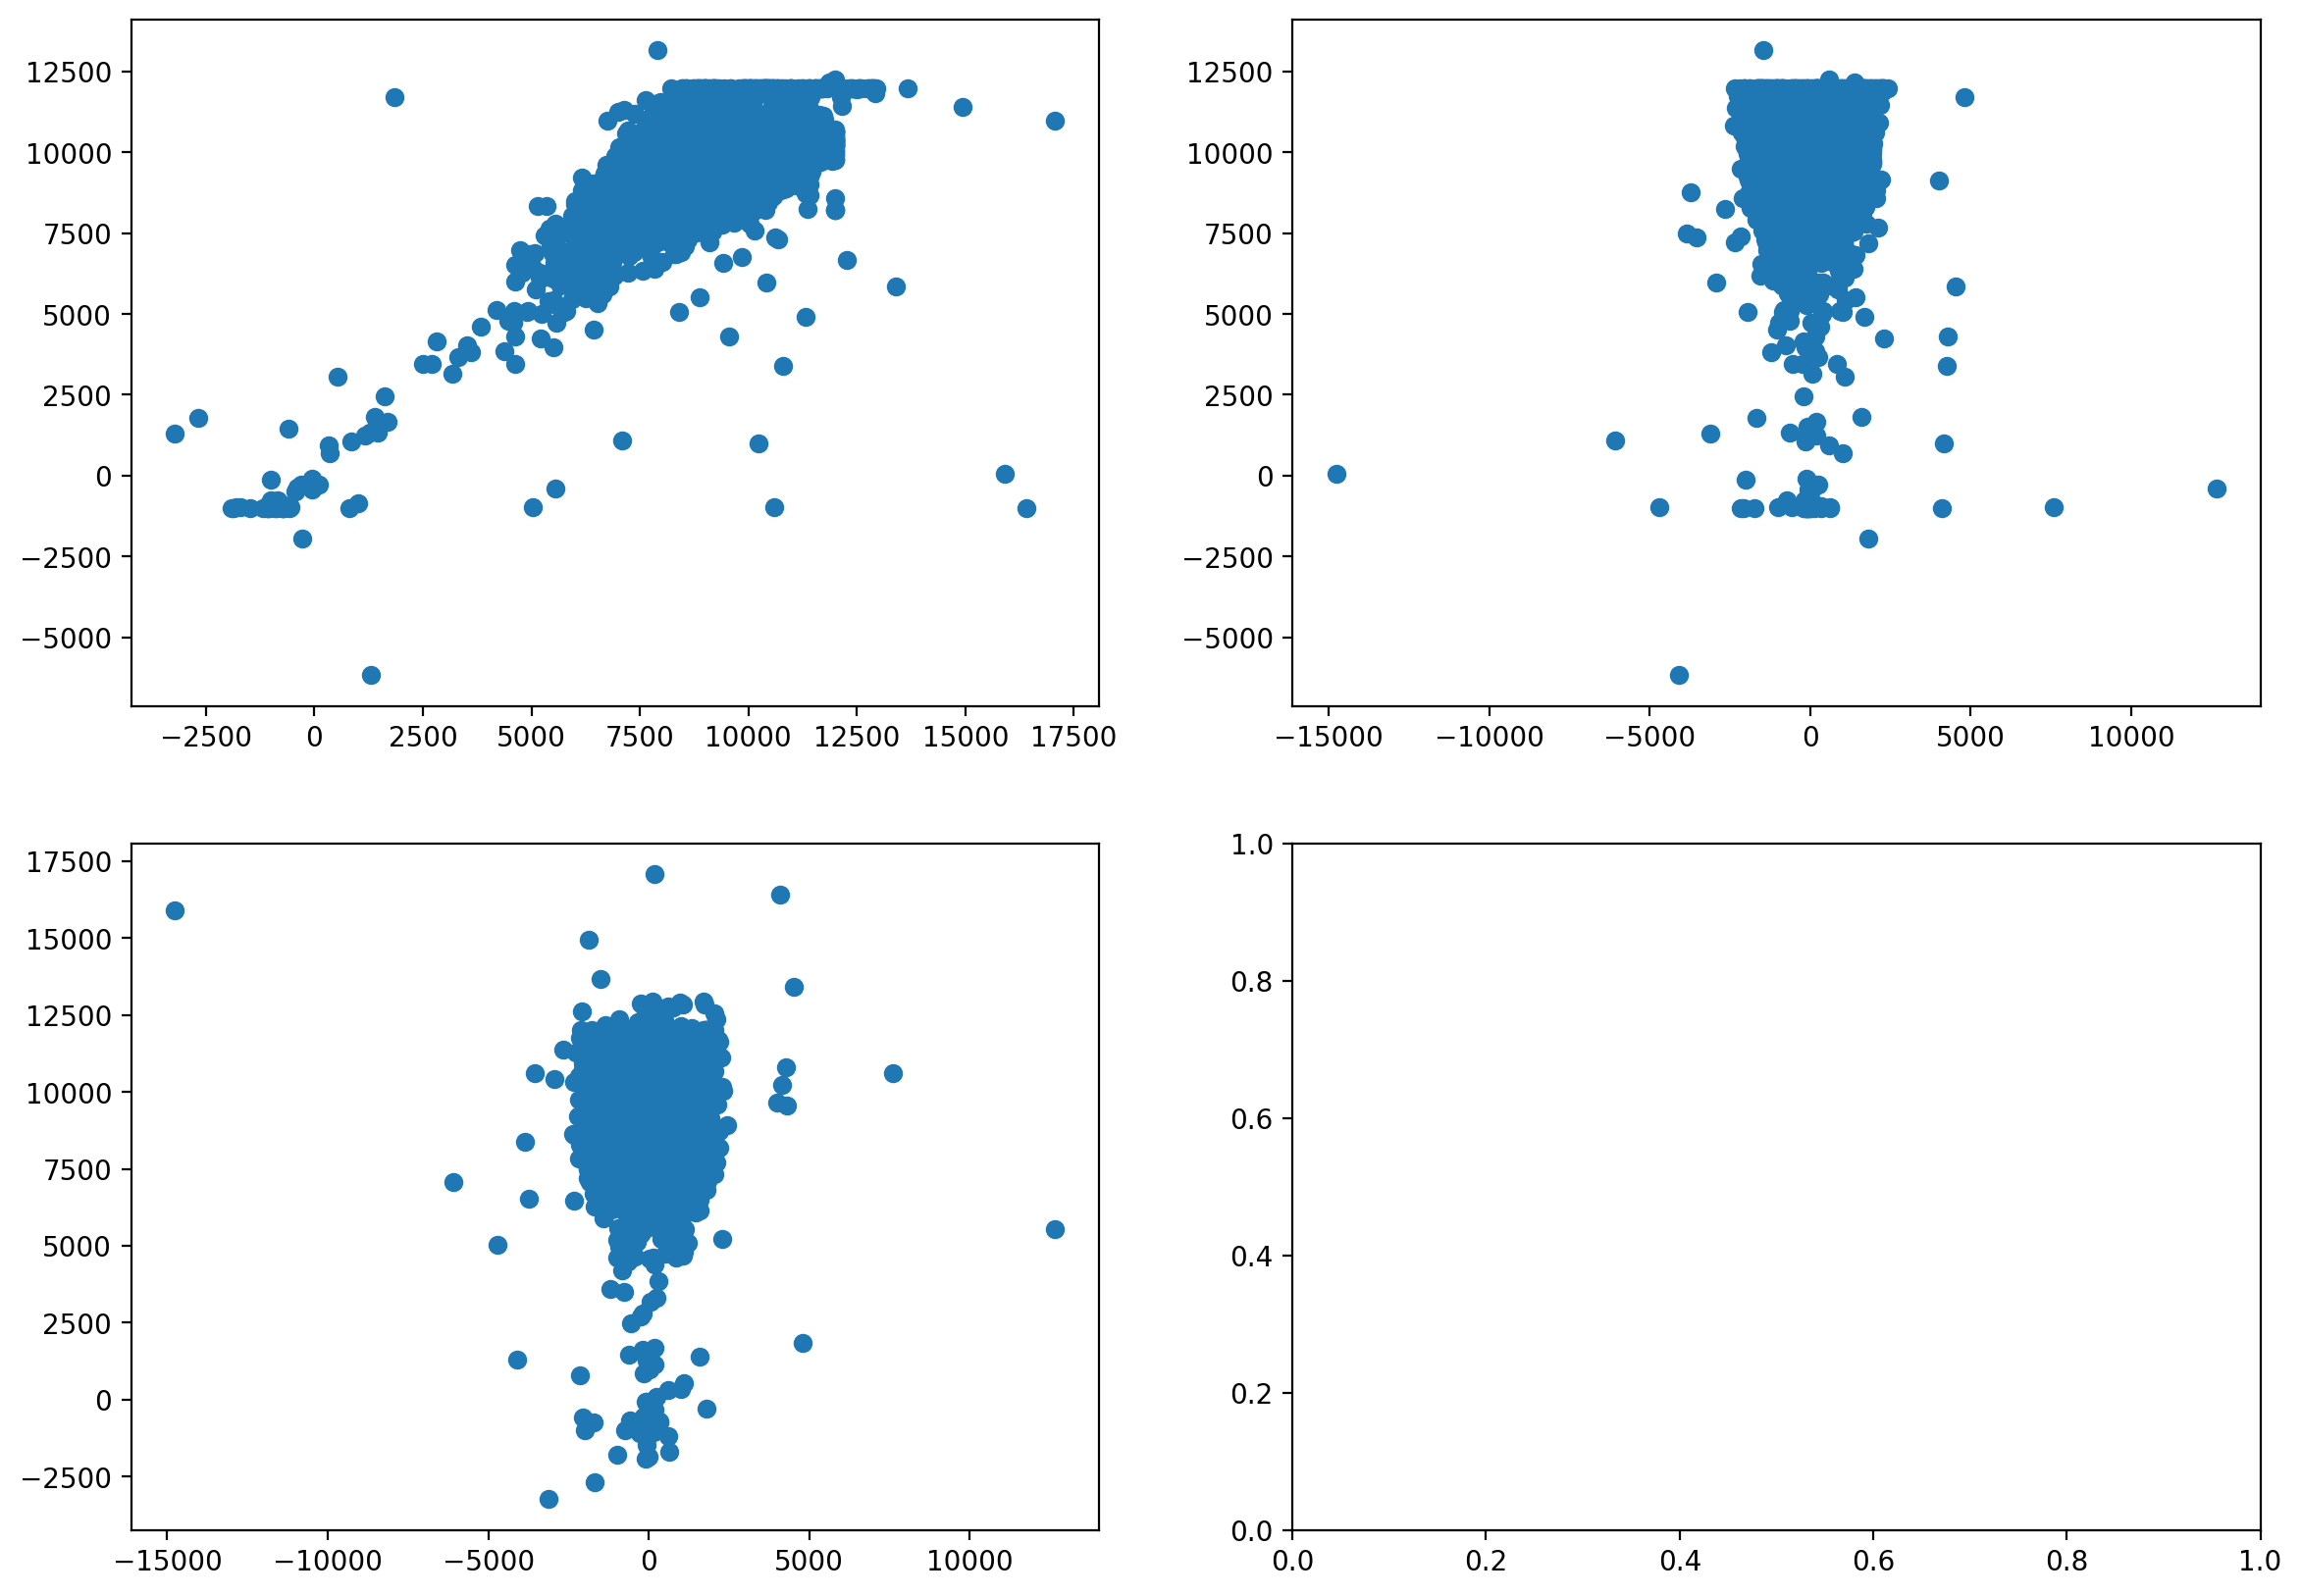

In [35]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

axs[0].scatter(z,y)
axs[1].scatter(x,y)
axs[2].scatter(x,z)

### Density Distribution ###

In [48]:
v_s = []
for p in points:
    if p[0] < -2000 or p[0] > 2000 or \
    p[1] < 8500 or p[1] > 10200 or \
    p[2] < 6850 or p[2] > 11350:
        continue
    v_s.append(p)

x_in,y_in,z_in = np.array(v_s).T

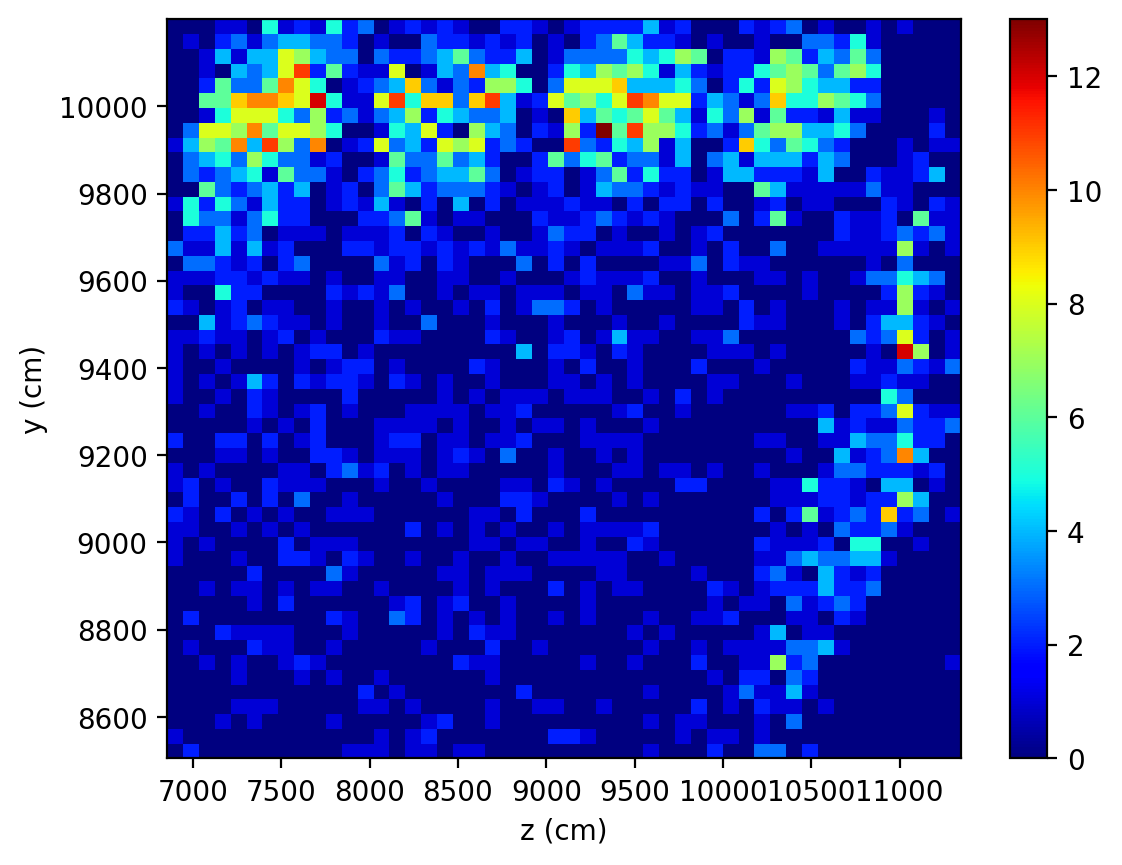

In [49]:
plt.hist2d(z_in, y_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("z (cm)")
plt.ylabel("y (cm)")
plt.colorbar()


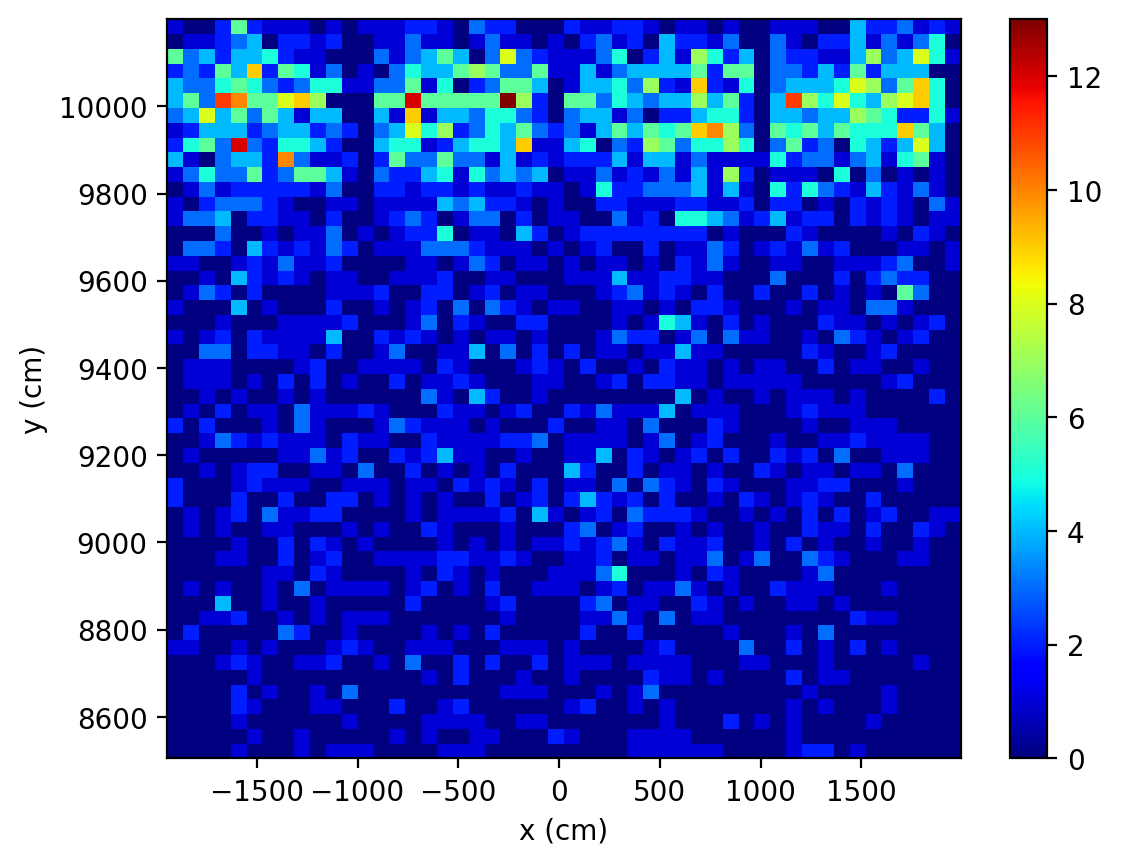

In [50]:
plt.hist2d(x_in, y_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.colorbar()

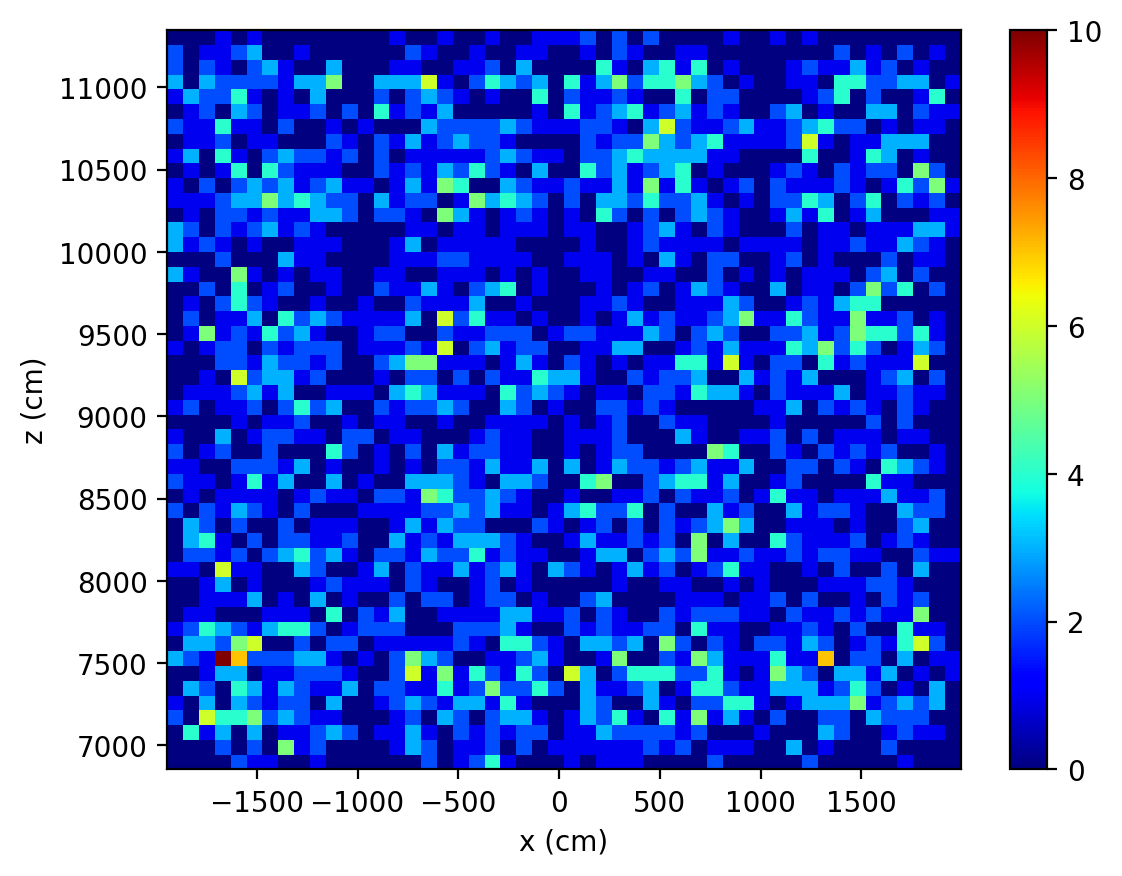

In [51]:
plt.hist2d(x_in, z_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("z (cm)")
plt.colorbar()

### Vertex Coordinate Distribution ###

Text(0.5, 1.0, 'z')

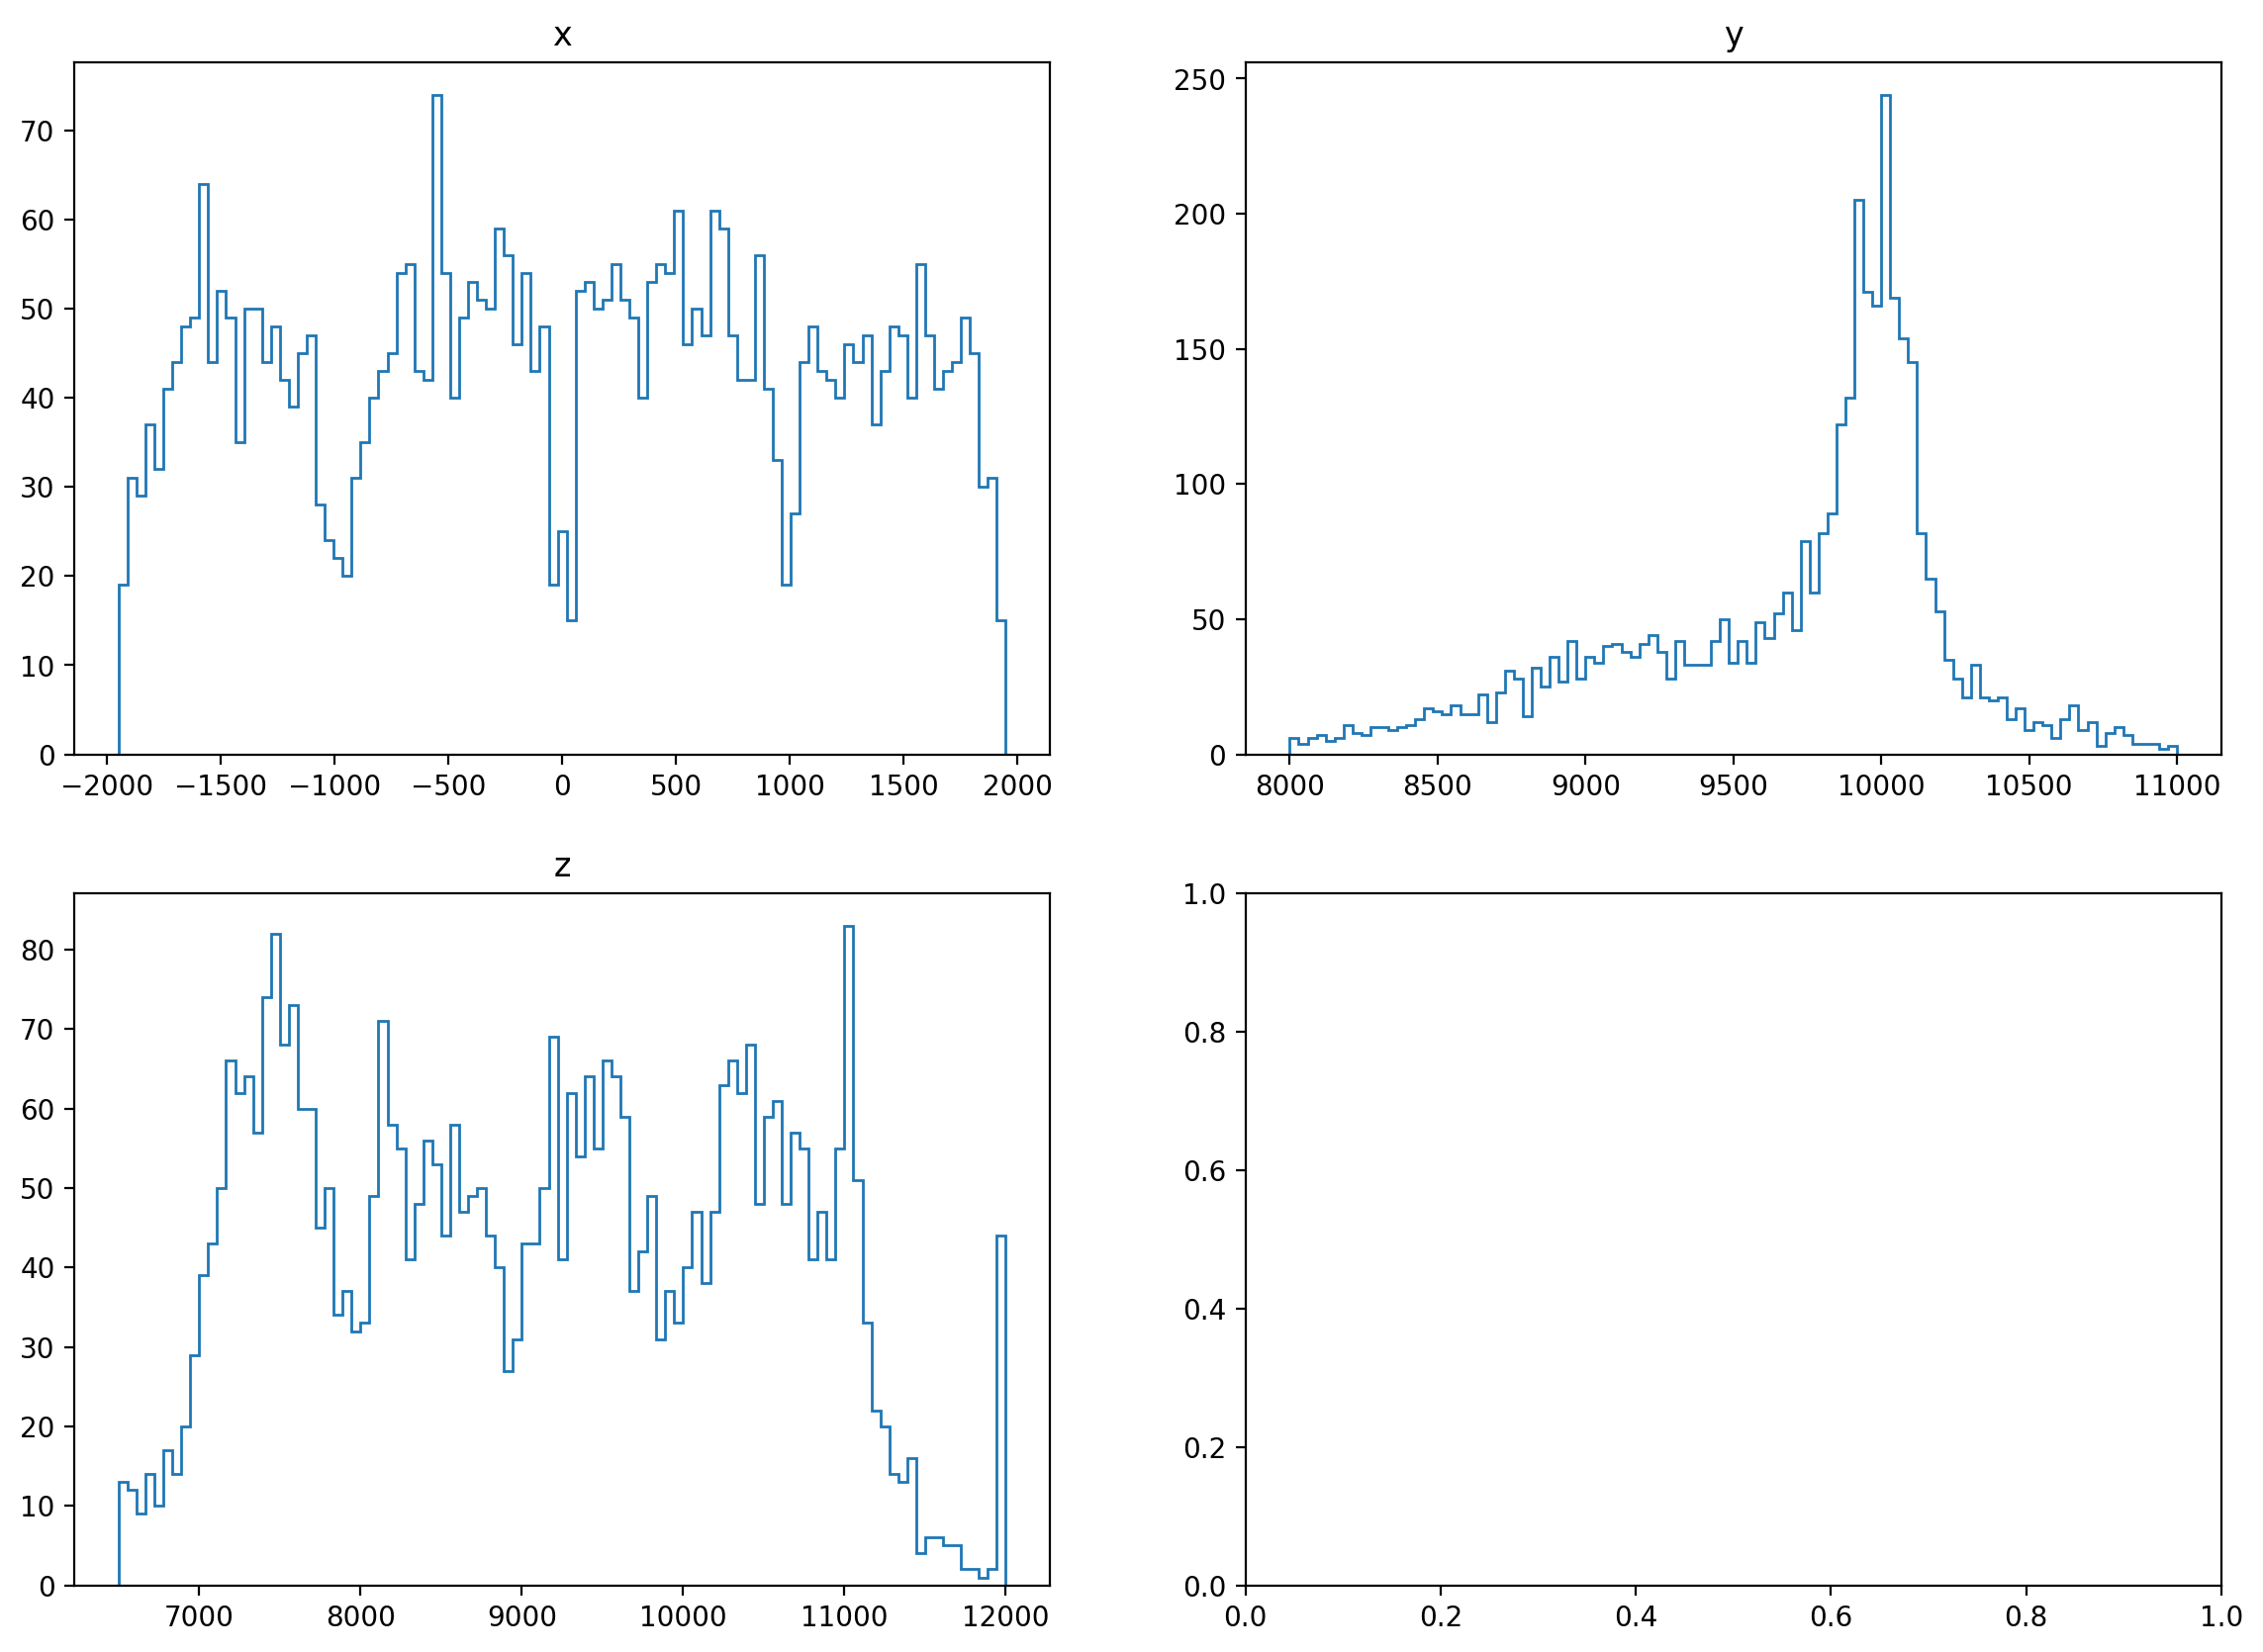

In [44]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

xCounts,xbins = np.histogram(x, bins=np.linspace(-1950, 1950, 100))
yCounts,ybins = np.histogram(y, bins=np.linspace(8000,11000, 100))
zCounts,zbins = np.histogram(z, bins=np.linspace(6500, 12000, 100))
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z")


## Vertices Below Layers ##

In [73]:
below = []
for p in points:
    if p[0] < -2000 or p[0] > 2000 or \
    p[1] < 8500 or p[1] > y_wall_top or \
    p[2] < 6850 or p[2] > 12000:
        continue
    below.append(p)
print("Number of vertices in detector below layers:", len(below))
x_b, y_b, z_b = np.array(below).T
print("Survival Rate for below layers:", len(below)/len(points))

Number of vertices in detector below layers: 1783
Survival Rate for below layers: 0.40624287992709046


## Vertex Error Distribution ##

In [13]:
points = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            # Inside the detector
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0.5, 1.0, 'Distance error')

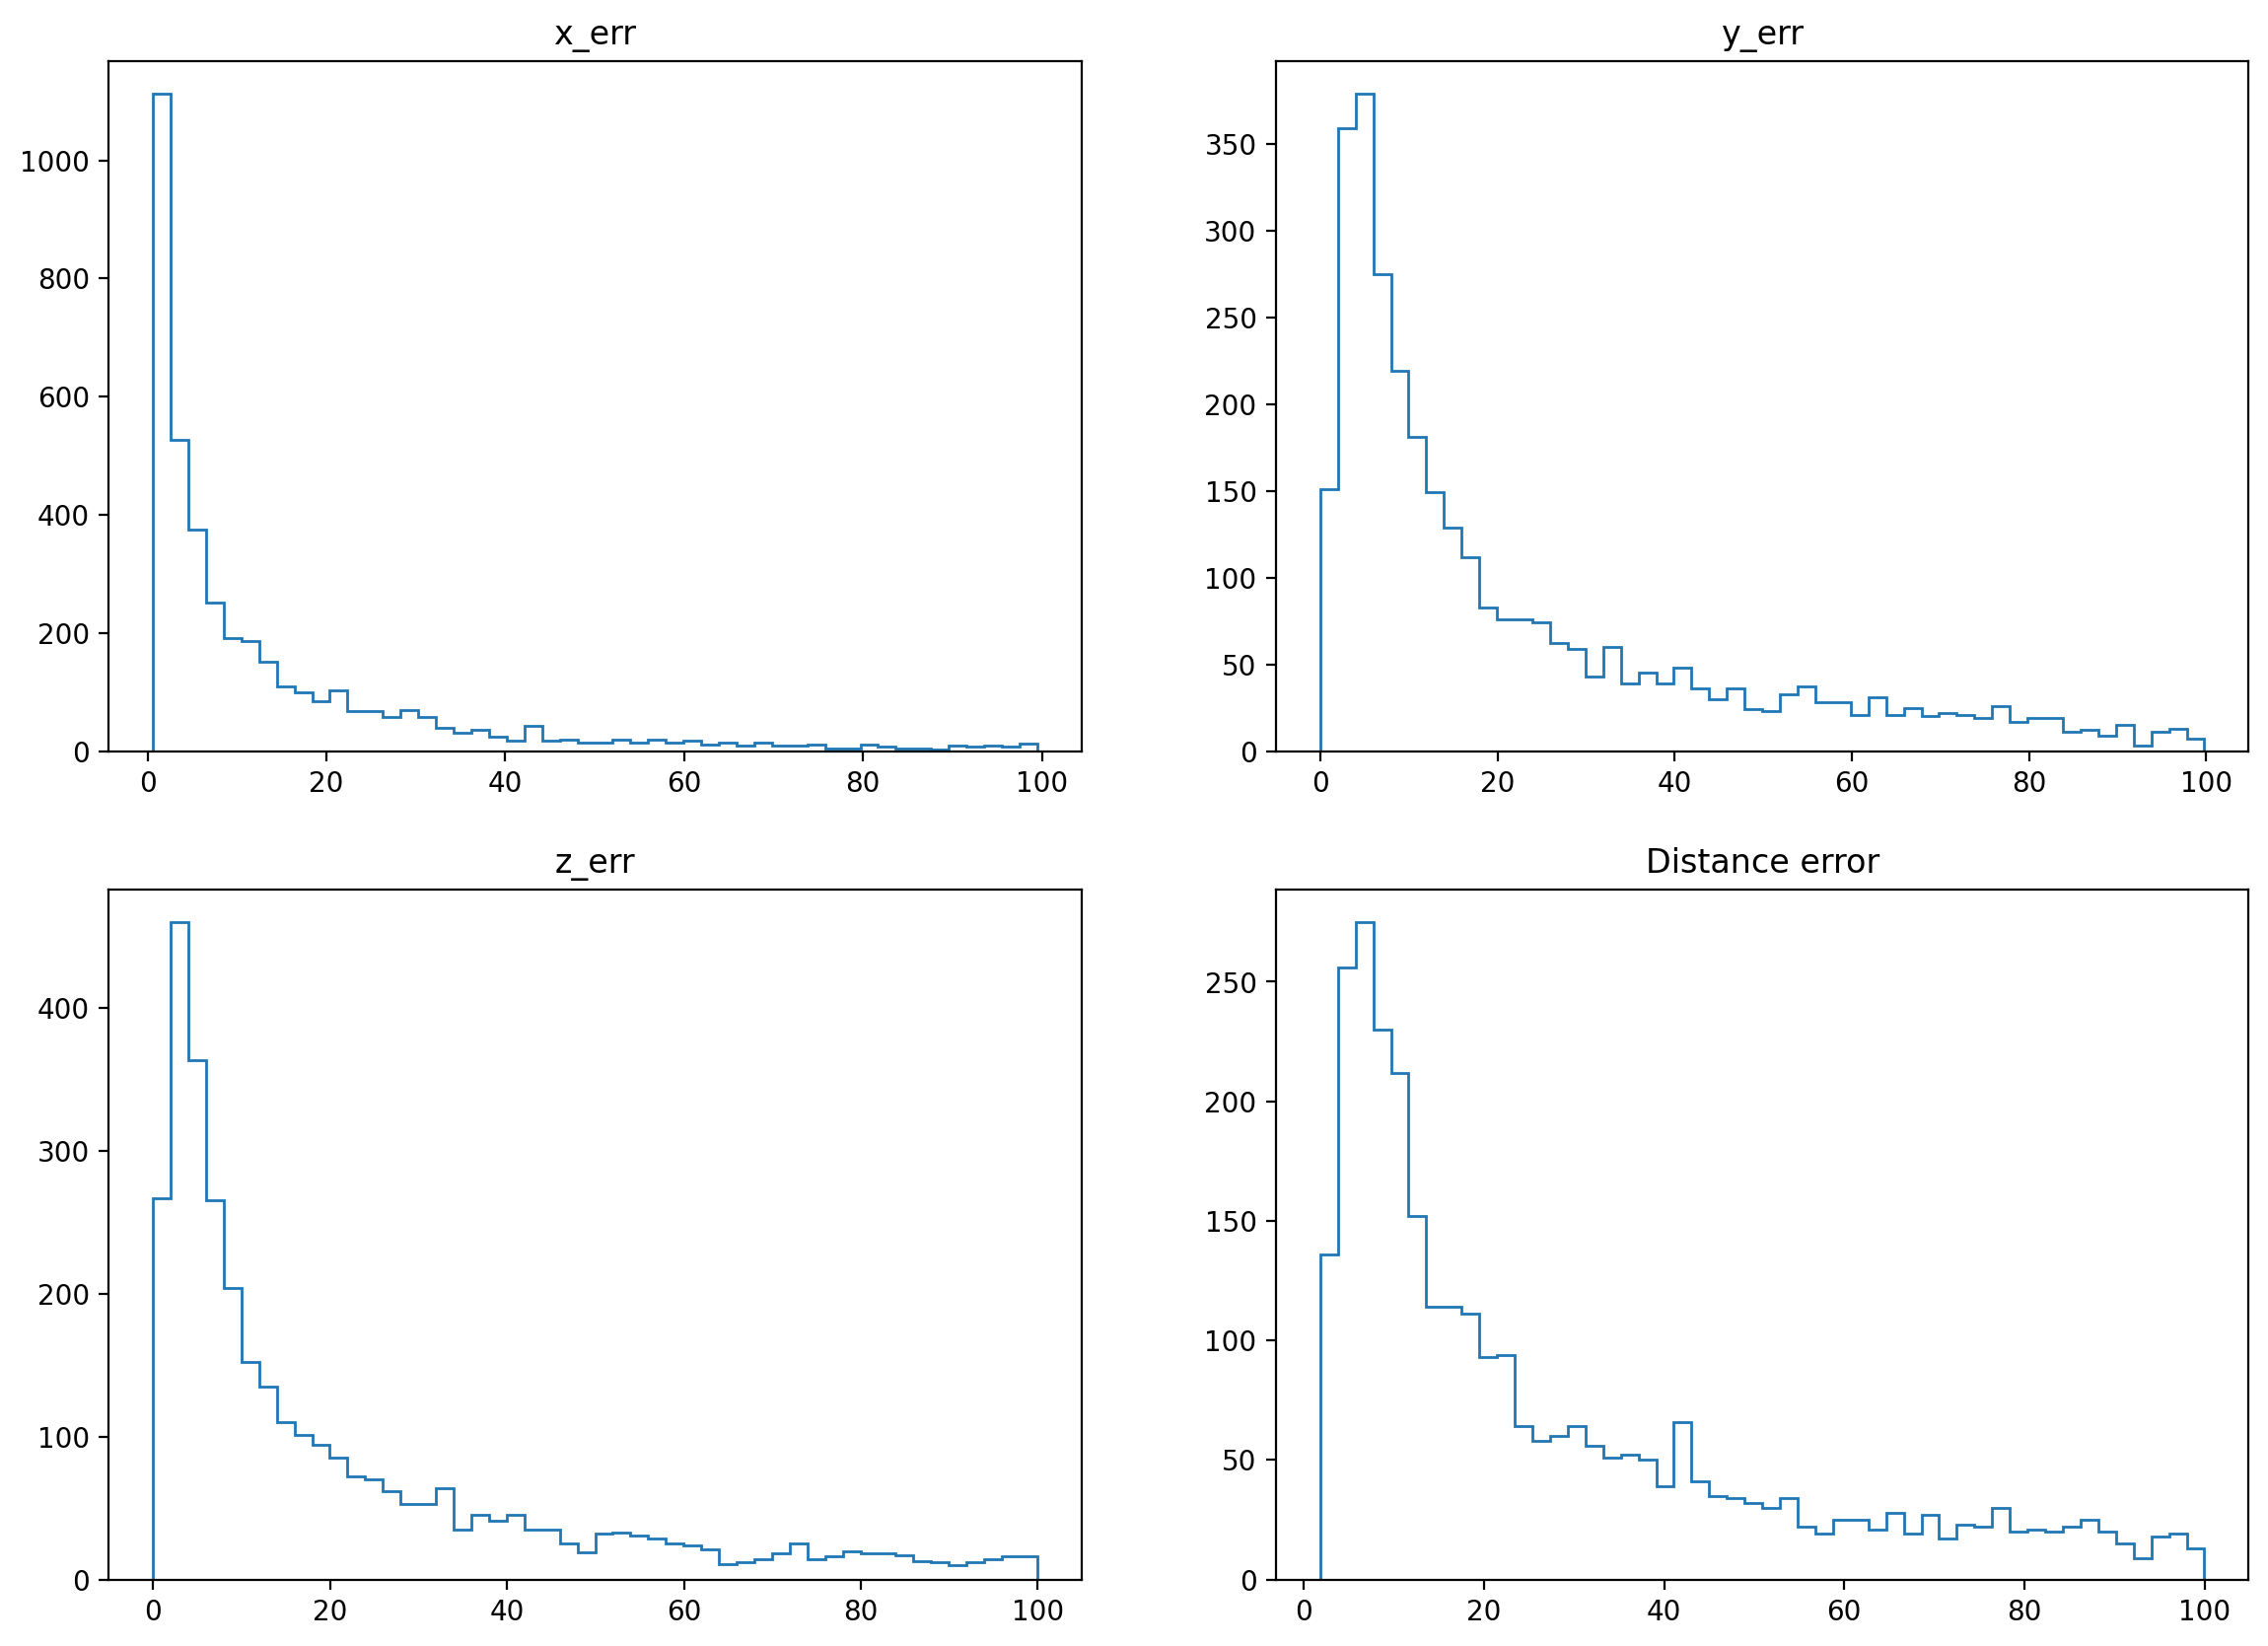

In [14]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

x,y,z = np.array(points).T
d = np.sqrt(x**2 + y**2 + z**2)
zoomx = []; zoomy =[]; zoomz=[]
zoomd = []
for i in range(len(x)):
    if x[i] < 100:
        zoomx.append(x[i])
    if y[i] < 100:
        zoomy.append(y[i])
    if z[i] < 100:
        zoomz.append(z[i])
    if d[i] < 100:
        zoomd.append(d[i])
xCounts,xbins = np.histogram(zoomx, bins=50)
yCounts,ybins = np.histogram(zoomy, bins=50)
zCounts,zbins = np.histogram(zoomz, bins=50)
dCounts,dbins = np.histogram(zoomd, bins=50)
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x_err")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y_err")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z_err")
axs[3].stairs(dCounts,dbins)
axs[3].set_title("Distance error")

In [15]:
dists = [0.01,1,2,5,10,25,50,100]
n = []
for i in range(len(dists)):
    n.append(0)
for err in d:
    for i in range(len(dists)):
        if err > dists[i]:
            n[i]+=1
for i in range(len(n)):
    print("Percentage of data with an error greater than " + str(dists[i]) + " cm:", n[i]/nVertices)

Percentage of data with an error greater than 0.01 cm: 1.0
Percentage of data with an error greater than 1 cm: 1.0
Percentage of data with an error greater than 2 cm: 0.9993164730006835
Percentage of data with an error greater than 5 cm: 0.9314194577352473
Percentage of data with an error greater than 10 cm: 0.7878787878787878
Percentage of data with an error greater than 25 cm: 0.5803144224196856
Percentage of data with an error greater than 50 cm: 0.4349510138983823
Percentage of data with an error greater than 100 cm: 0.3089542036910458


## Vertex Average Beta vs Error ##

In [16]:
points = []
betas = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    file_tracks = events["tracks"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        tracks = file_tracks[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            v_tracks = []
            beta = 0
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                v = np.sqrt((track.Ax/track.At)**2 + (track.Ay/track.At)**2 + (track.Az/track.At)**2)
                beta += v/c
            beta = beta/len(vertex.tracks)
            betas.append(beta)
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0, 0.5, 'Beta')

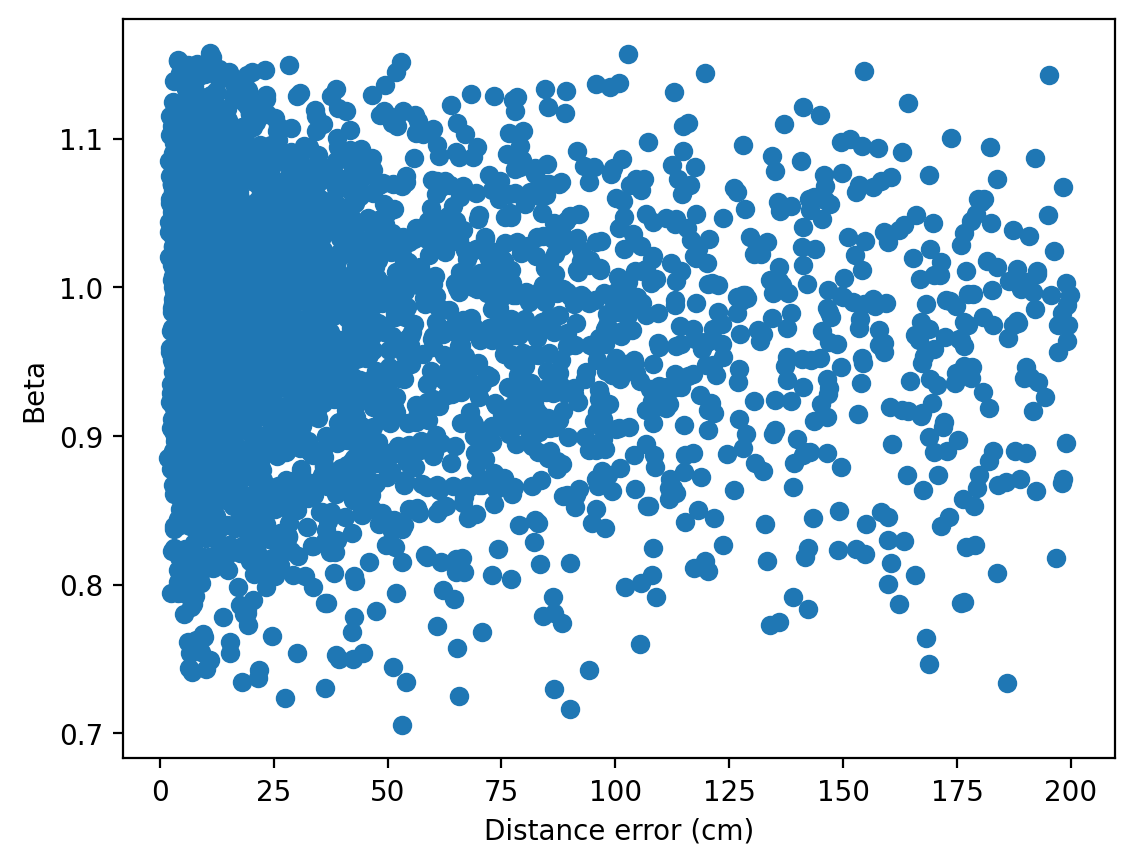

In [17]:
dists = []
trimmed_betas = []
for i in range(len(betas)):
    dist = (np.sqrt(points[i][0]**2 + points[i][1]**2 + points[i][2]**2))
    if dist < 200:
        dists.append(dist)
        trimmed_betas.append(betas[i])
        
plt.scatter(dists, trimmed_betas)
plt.xlabel("Distance error (cm)")
plt.ylabel("Beta")

# Signal #

In [74]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/LLP"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

5


## Vertex Positions ##

### Get Vertices ###

In [75]:
points = []
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            points.append((vertex.x0, vertex.y0, vertex.z0))
print("Number of vertices:", len(points))
x,y,z = np.array(points).T



Number of vertices: 118152


### Scatter Plot ###

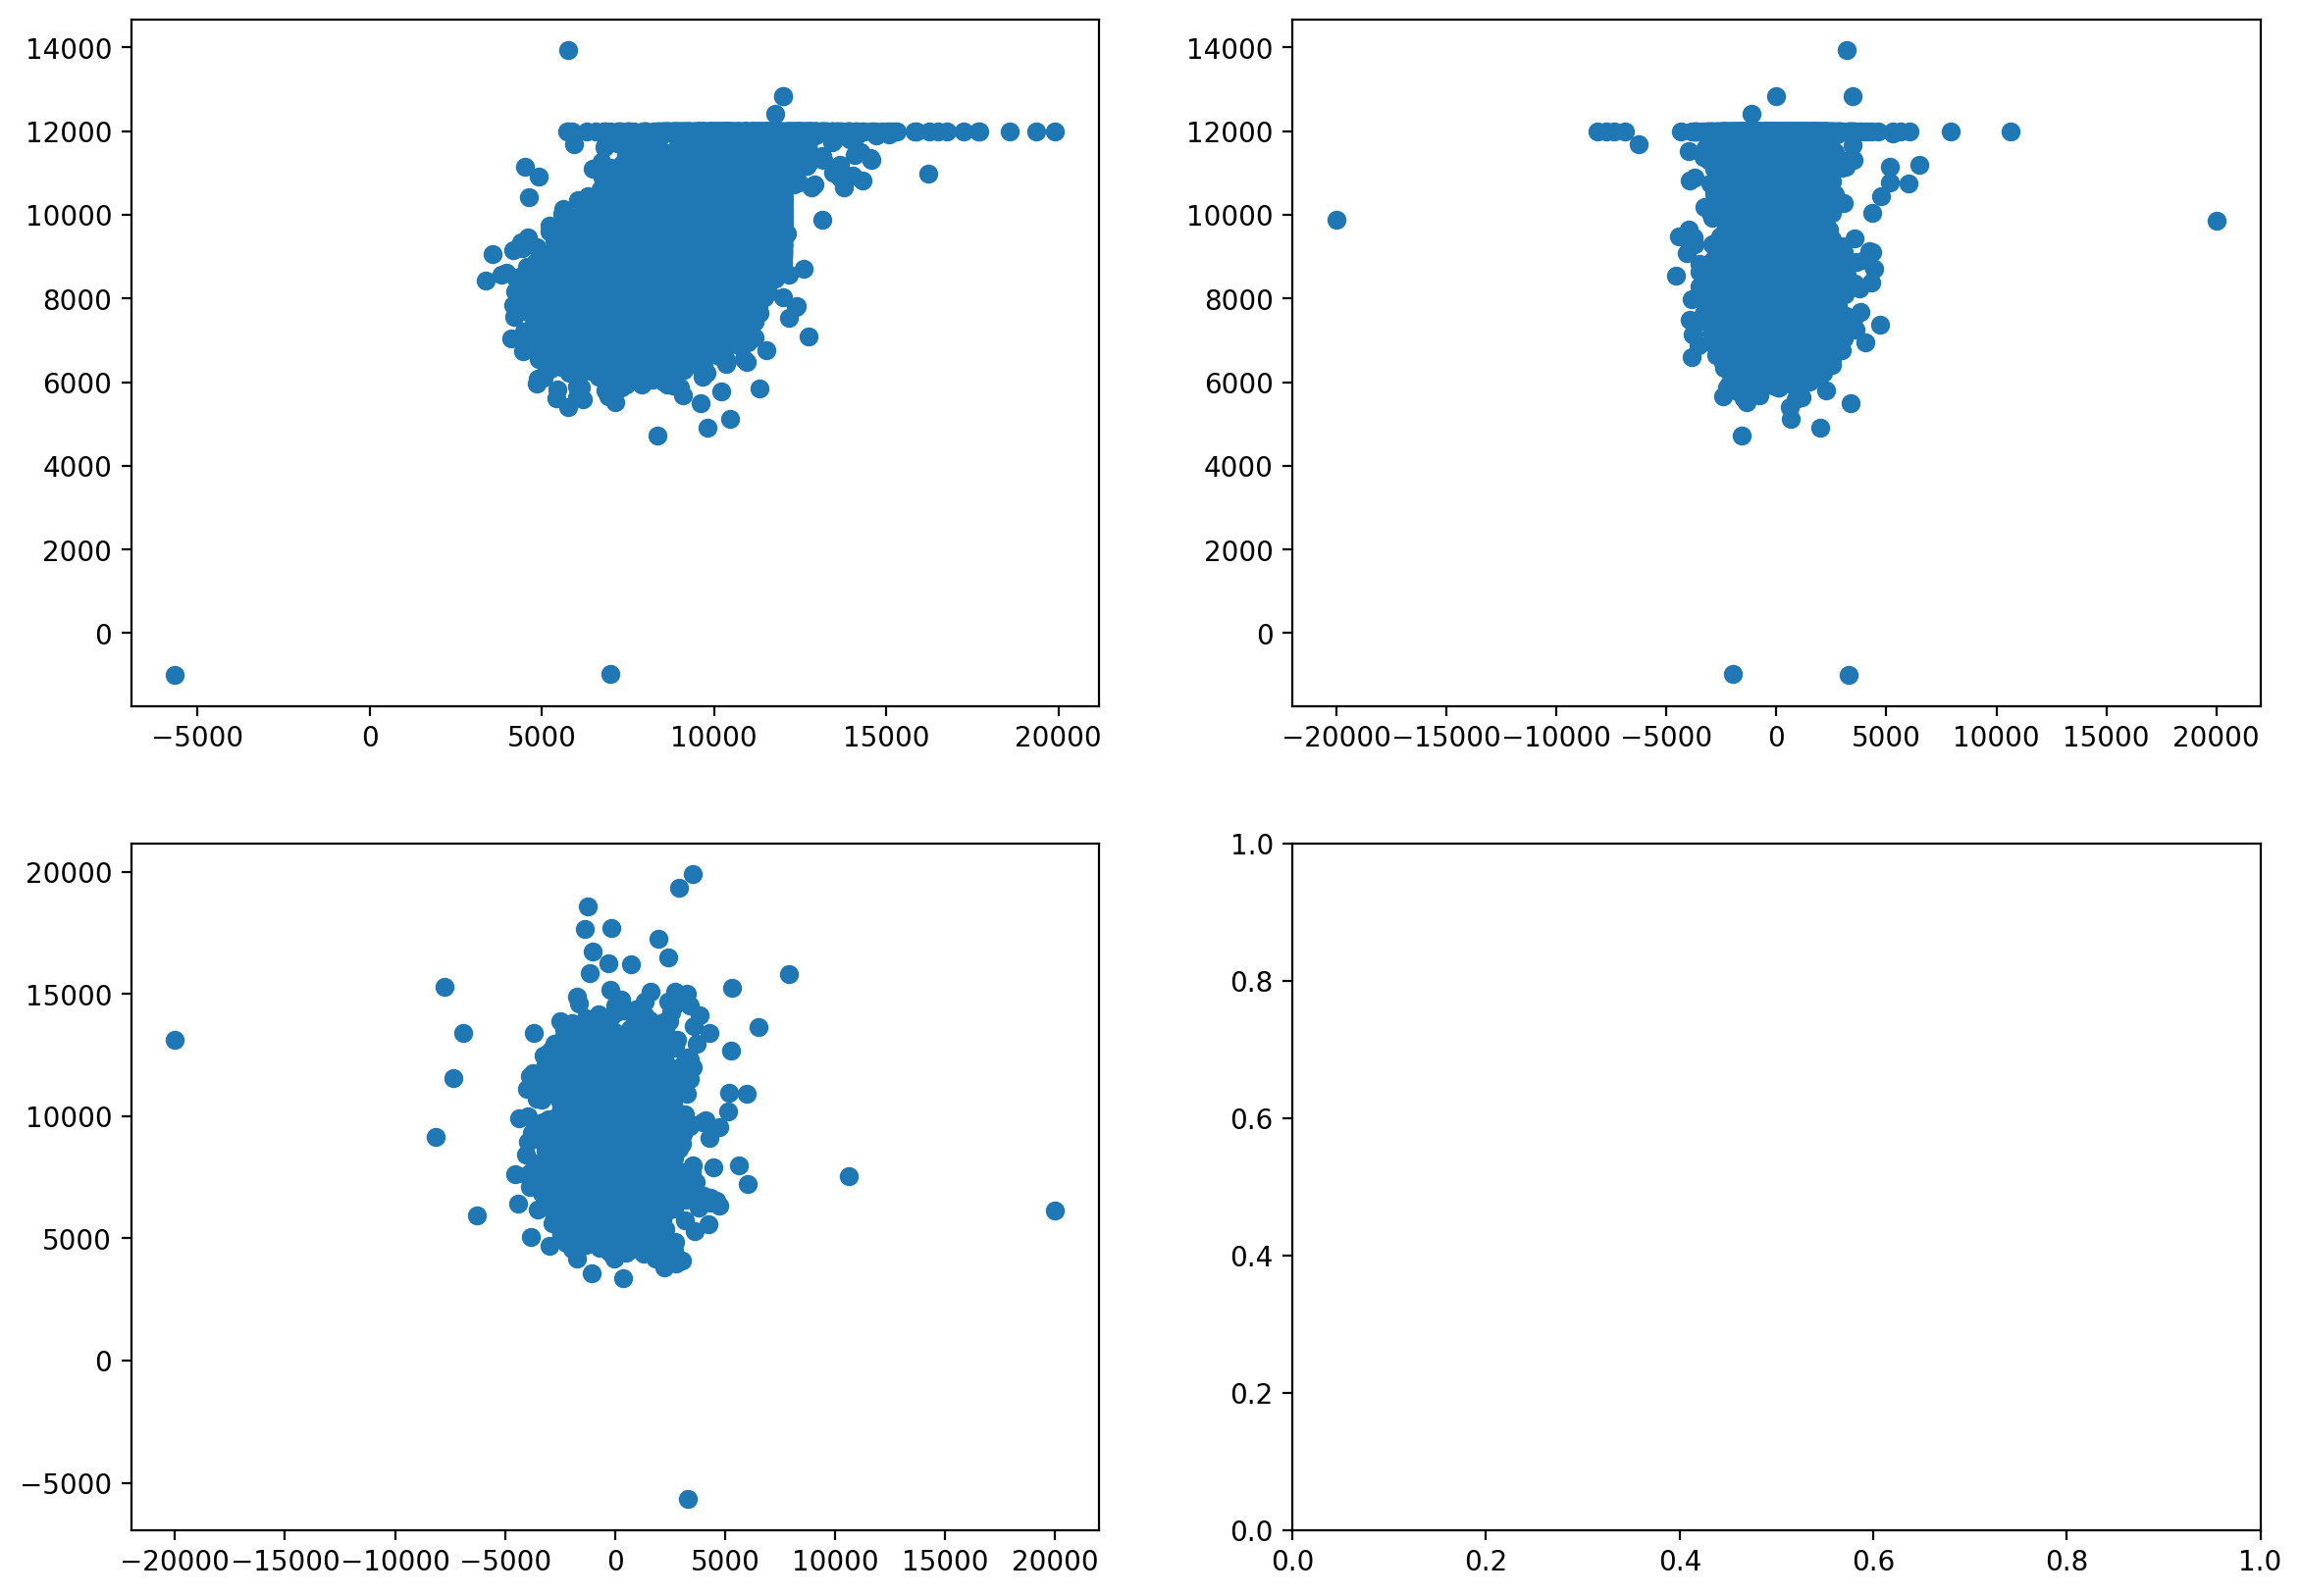

In [57]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

axs[0].scatter(z,y)
axs[1].scatter(x,y)
axs[2].scatter(x,z)

### Density Distribution ###

In [58]:
v_s = []
for p in points:
    if p[0] < -2000 or p[0] > 2000 or \
    p[1] < 8500 or p[1] > 10200 or \
    p[2] < 6850 or p[2] > 11350:
        continue
    v_s.append(p)

x_in,y_in,z_in = np.array(v_s).T

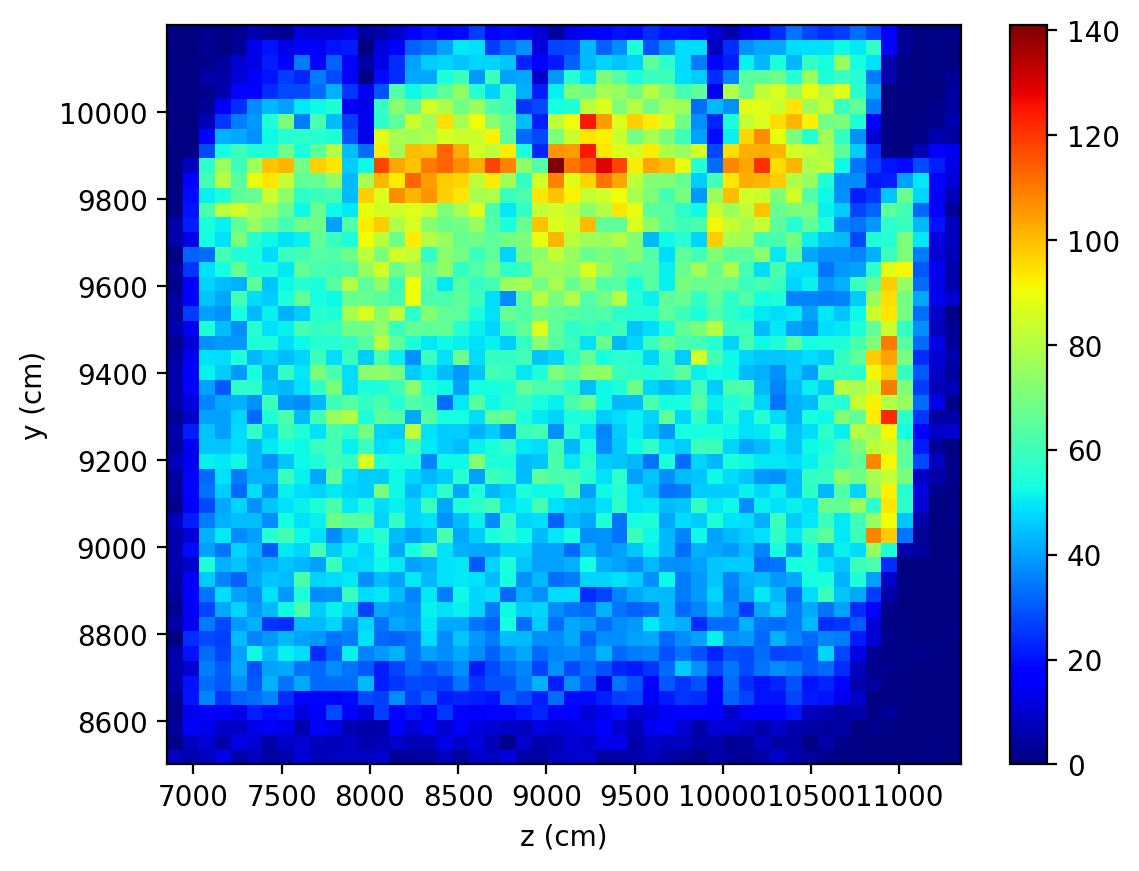

In [59]:
plt.hist2d(z_in, y_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("z (cm)")
plt.ylabel("y (cm)")
plt.colorbar()


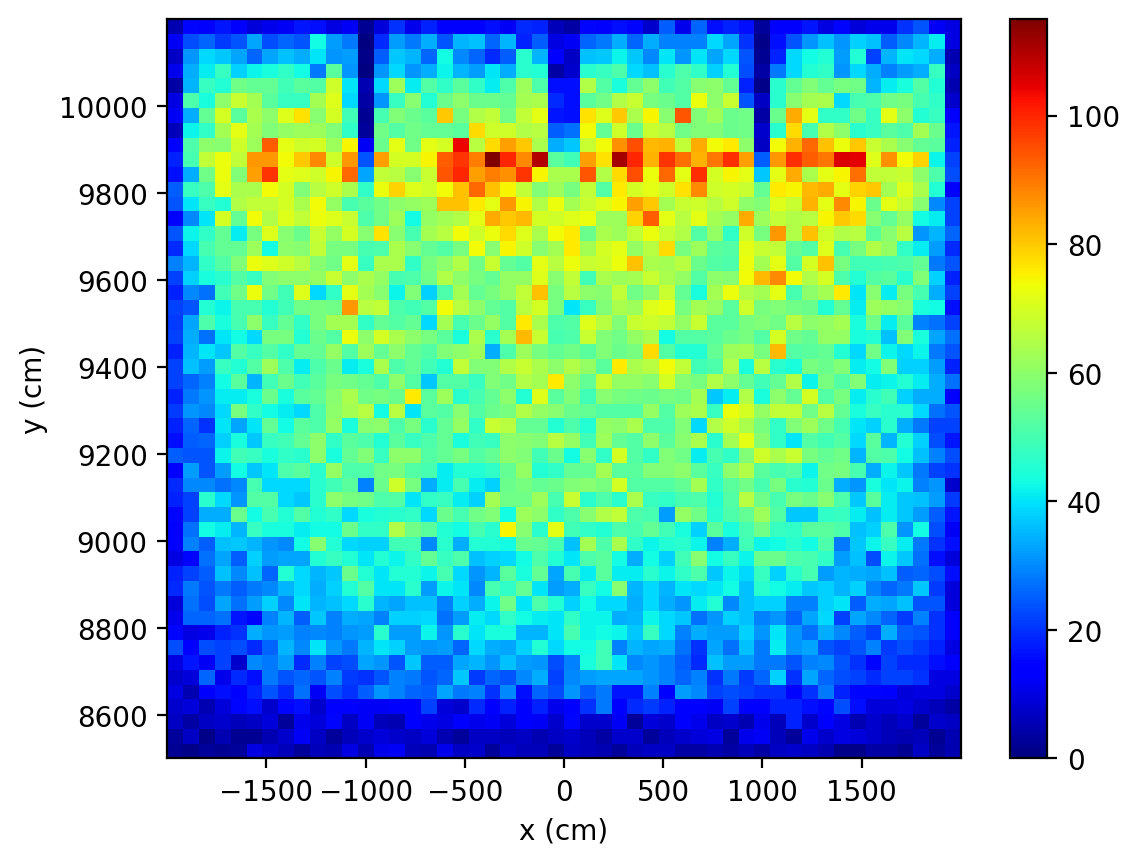

In [60]:
plt.hist2d(x_in, y_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.colorbar()

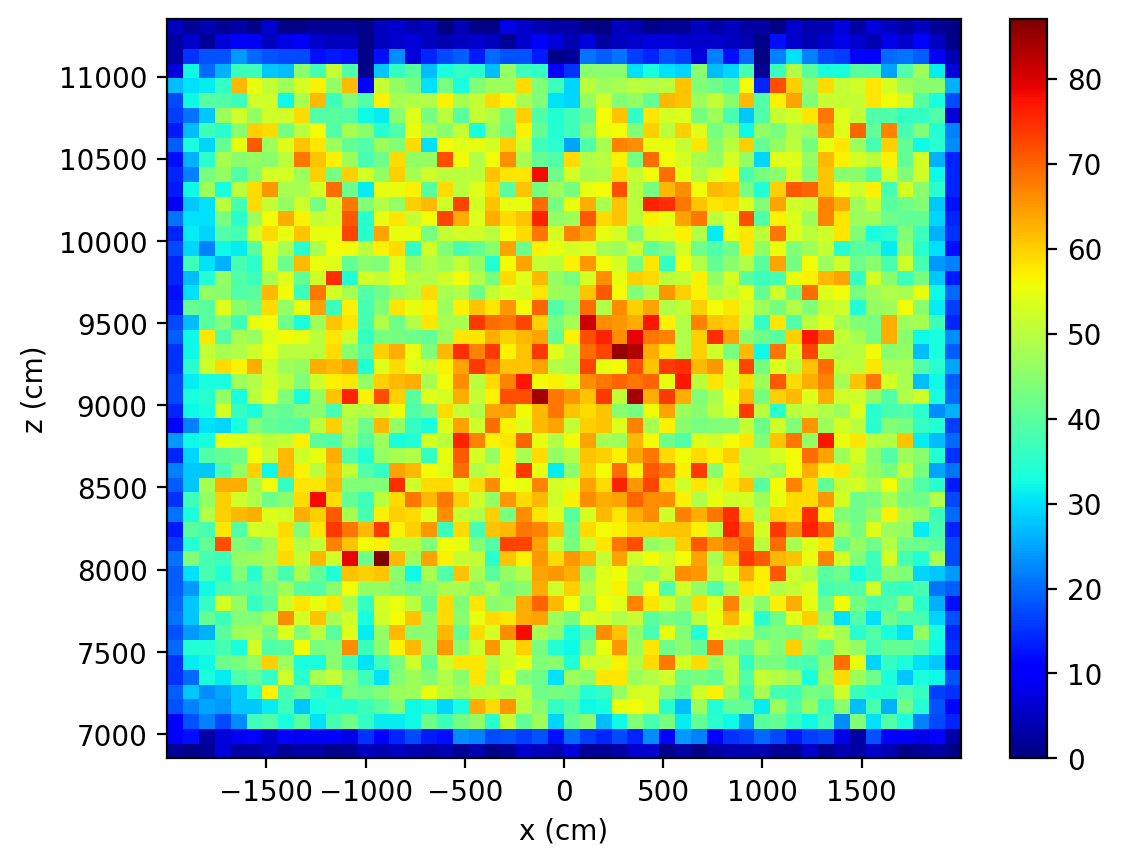

In [61]:
plt.hist2d(x_in, z_in, bins=(50, 50), cmap=plt.cm.jet)
plt.xlabel("x (cm)")
plt.ylabel("z (cm)")
plt.colorbar()

### Vertex Coordinate Distribution ###

Text(0.5, 1.0, 'z')

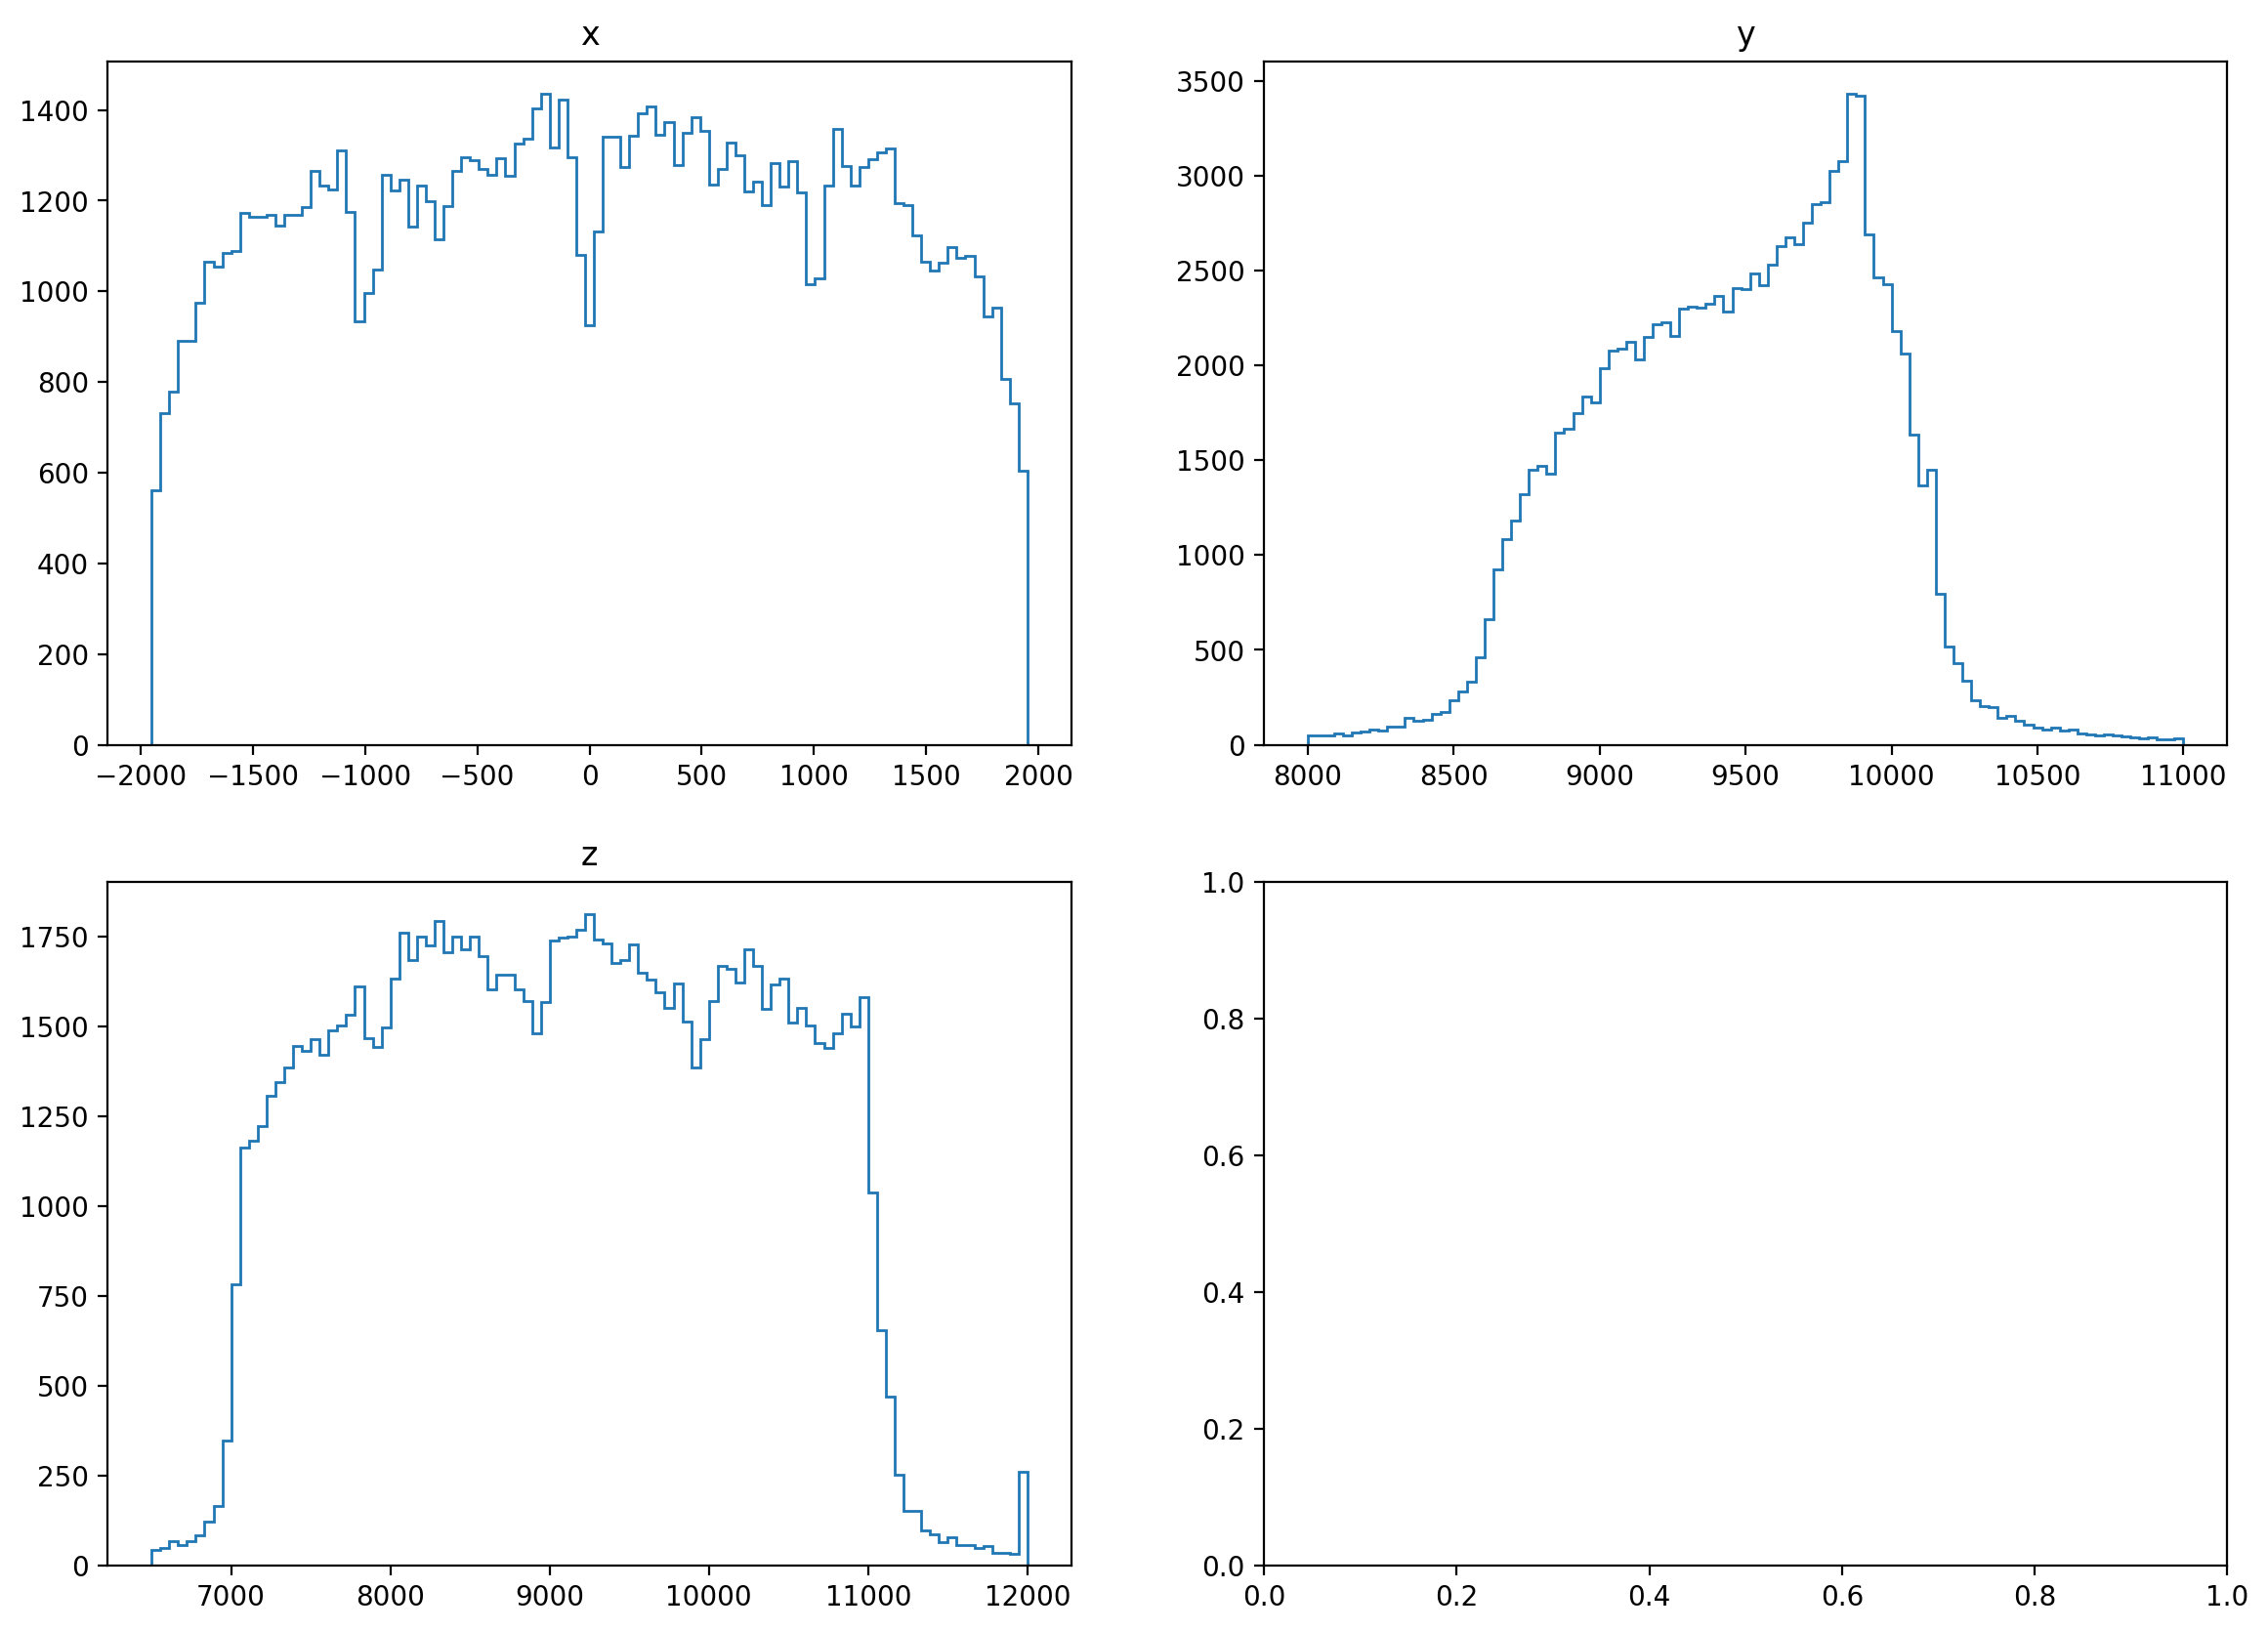

In [62]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

xCounts,xbins = np.histogram(x, bins=np.linspace(-1950, 1950, 100))
yCounts,ybins = np.histogram(y, bins=np.linspace(8000,11000, 100))
zCounts,zbins = np.histogram(z, bins=np.linspace(6500, 12000, 100))
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z")


## Vertices Below Layers ##

In [76]:
maxTop = y_layer_starts[2]
below = []
for p in points:
    if p[0] < -2000 or p[0] > 2000 or \
    p[1] < 8500 or p[1] > maxTop or \
    p[2] < 6850 or p[2] > 12000:
        continue
    below.append(p)
print("Number of vertices in detector below layers:", len(below))
x_b, y_b, z_b = np.array(below).T
print("Survival Rate for below layers:", len(below)/len(points))

Number of vertices in detector below layers: 91488
Survival Rate for below layers: 0.7743245988218566


## Vertex Error Distribution ##

In [64]:
points = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            # Inside the detector
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0.5, 1.0, 'Distance error')

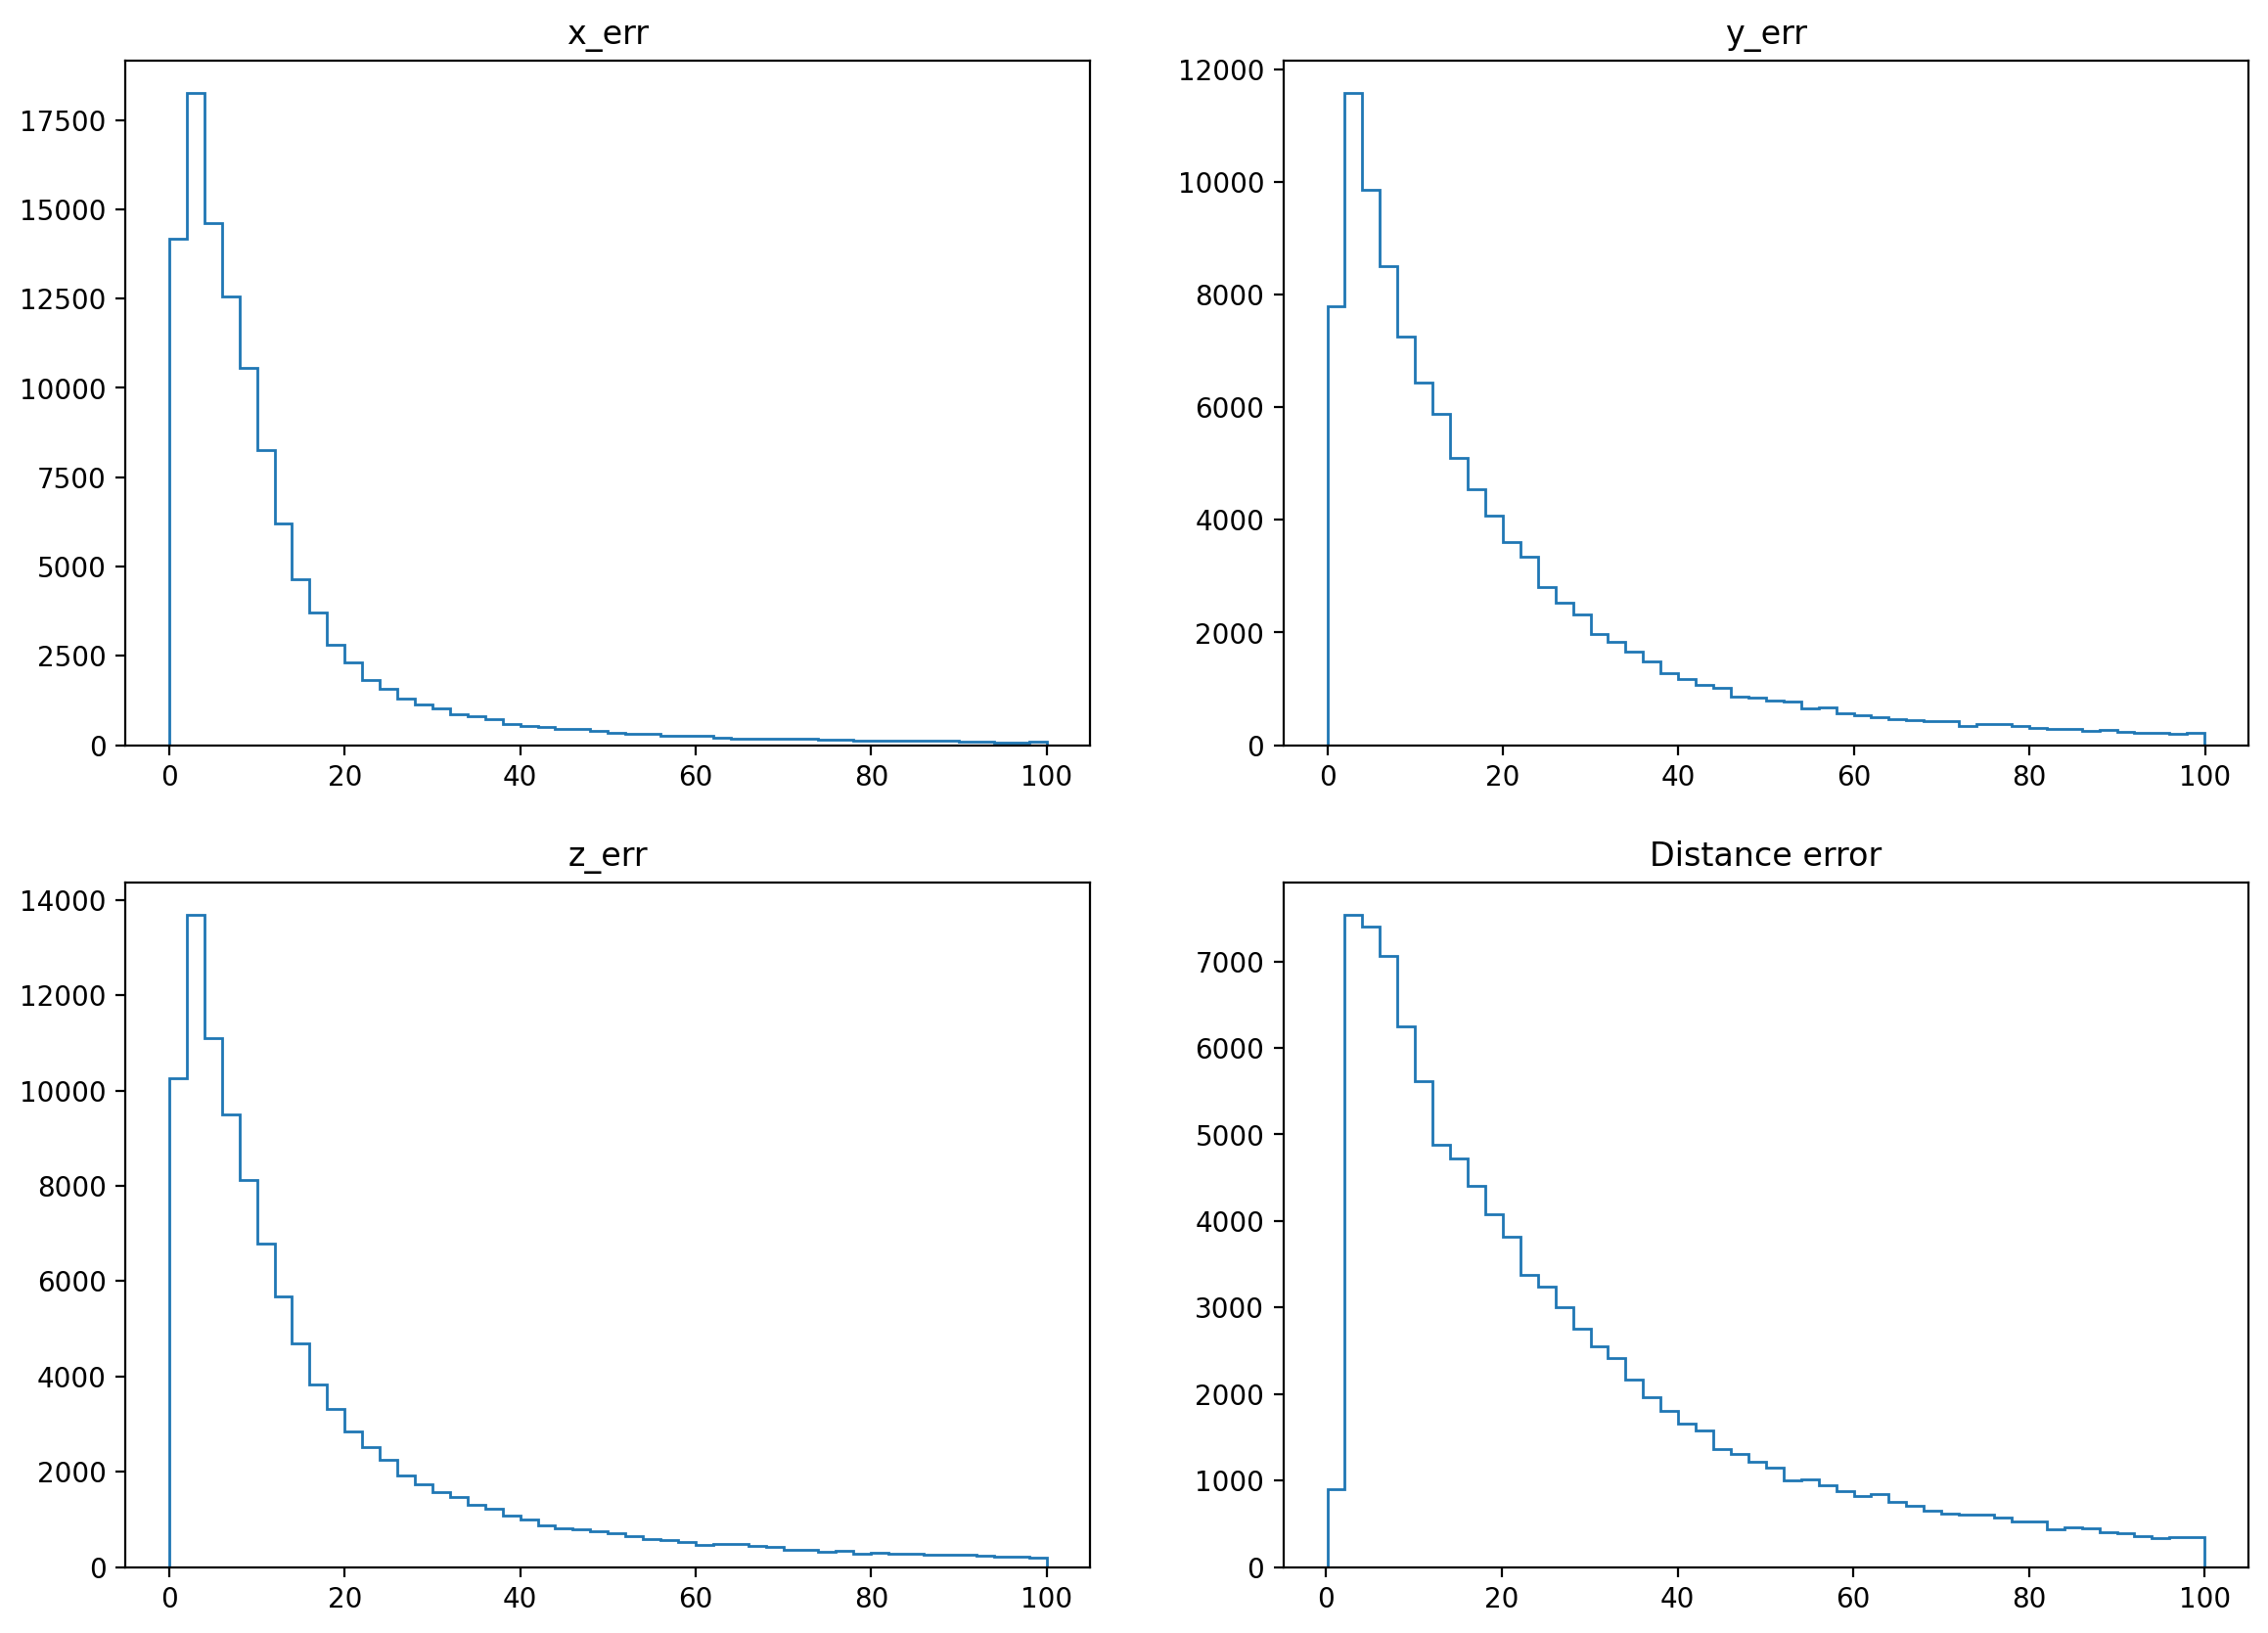

In [65]:
fig,axs=plt.subplots(2,2,figsize=(14,10))
axs=axs.flatten().tolist()

x,y,z = np.array(points).T
d = np.sqrt(x**2 + y**2 + z**2)
zoomx = []; zoomy =[]; zoomz=[]
zoomd = []
for i in range(len(x)):
    if x[i] < 100:
        zoomx.append(x[i])
    if y[i] < 100:
        zoomy.append(y[i])
    if z[i] < 100:
        zoomz.append(z[i])
    if d[i] < 100:
        zoomd.append(d[i])
xCounts,xbins = np.histogram(zoomx, bins=50)
yCounts,ybins = np.histogram(zoomy, bins=50)
zCounts,zbins = np.histogram(zoomz, bins=50)
dCounts,dbins = np.histogram(zoomd, bins=50)
axs[0].stairs(xCounts,xbins)
axs[0].set_title("x_err")
axs[1].stairs(yCounts,ybins)
axs[1].set_title("y_err")
axs[2].stairs(zCounts,zbins)
axs[2].set_title("z_err")
axs[3].stairs(dCounts,dbins)
axs[3].set_title("Distance error")

In [66]:
dists = [0.01,1,2,5,10,25,50,100]
n = []
for i in range(len(dists)):
    n.append(0)
for err in d:
    for i in range(len(dists)):
        if err > dists[i]:
            n[i]+=1
for i in range(len(n)):
    print("Percentage of data with an error greater than " + str(dists[i]) + " cm:", n[i]/nVertices)

Percentage of data with an error greater than 0.01 cm: 1.0
Percentage of data with an error greater than 1 cm: 0.9999915363260884
Percentage of data with an error greater than 2 cm: 0.9954296160877514
Percentage of data with an error greater than 5 cm: 0.9005349041912113
Percentage of data with an error greater than 10 cm: 0.7563477554336786
Percentage of data with an error greater than 25 cm: 0.47907779809059514
Percentage of data with an error greater than 50 cm: 0.26354187825851444
Percentage of data with an error greater than 100 cm: 0.1301205227165008


## Vertex Average Beta vs Error ##

In [16]:
points = []
betas = []
nVertices = 0
for f in pathList:
    events=joblib.load(f)
    file_vertices = events["vertices"]
    file_tracks = events["tracks"]
    for i in range(len(file_vertices)):
        vertices = file_vertices[i]
        tracks = file_tracks[i]
        nVertices += len(vertices)
        if len(vertices) == 0:
            continue
        for vertex in vertices:
            v_tracks = []
            beta = 0
            for t_index in vertex.tracks:
                v_tracks.append(tracks[t_index])
            for track in v_tracks:
                v = np.sqrt((track.Ax/track.At)**2 + (track.Ay/track.At)**2 + (track.Az/track.At)**2)
                beta += v/c
            beta = beta/len(vertex.tracks)
            betas.append(beta)
            points.append((np.sqrt(vertex.cov[0][0]), np.sqrt(vertex.cov[1][1]), np.sqrt(vertex.cov[2][2])))


Text(0, 0.5, 'Beta')

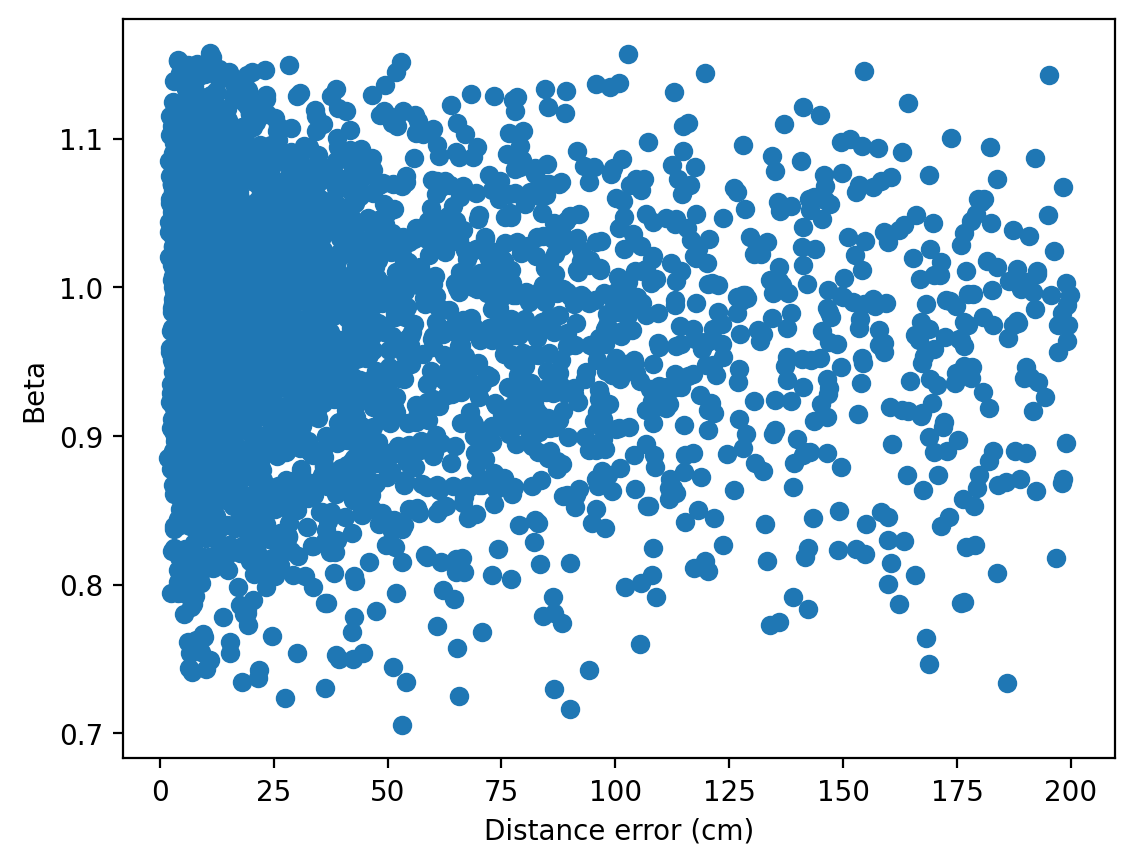

In [17]:
dists = []
trimmed_betas = []
for i in range(len(betas)):
    dist = (np.sqrt(points[i][0]**2 + points[i][1]**2 + points[i][2]**2))
    if dist < 200:
        dists.append(dist)
        trimmed_betas.append(betas[i])
        
plt.scatter(dists, trimmed_betas)
plt.xlabel("Distance error (cm)")
plt.ylabel("Beta")